## Get all the imports

In [ ]:
import numpy as np
from sklearn.datasets import make_classification, make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import Perceptron

## Generate Dataset

Data Shape: (1000, 2)


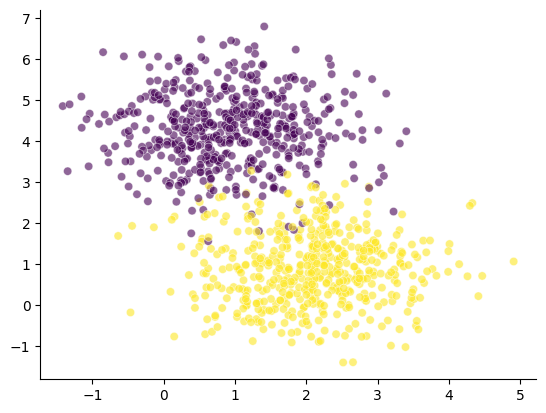

In [ ]:
# Define all the static variables here
seed = 0
num_samples, num_features, num_classes = 1000, 2, 2
class_sep = 2.5

# First create a dataset
X, Y = make_blobs(n_samples=num_samples, centers=2, cluster_std=0.9, random_state=seed)
# X, Y = make_classification(n_samples=num_samples, n_features=2, n_clusters_per_class=2, n_redundant=0, n_repeated=0, class_sep=2.5)
Y[np.where(Y==0)[0]] = -1
# Check out the shape
print("Data Shape:", X.shape)
# Plot the data
sns.scatterplot(x=X[:,0], y=X[:,1], c=Y, alpha=0.6)
sns.despine()
plt.show()

# Split the dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, shuffle=True)

## Define the Perceptron Model

In [ ]:
class CustomPerceptron:
    def __init__(self, num_features:int, lr:float=0.1):
        # Initialize the linear layer
        # Adding one for bias
        # self.W = np.random.normal(0, 0.1, (num_features+1))
        # self.W = np.random.exponential(size=(num_features+1))
        self.W = np.zeros((num_features+1))
        self.lr = lr

    # Define a custom activation function
    def activation_function(self, x):
        out = 1 if x >= 0 else -1
        return out

    # Define a custom objective function
    def loss_fn(self, pred, target):
        return target*pred

    # The forward pass
    def forward(self, x):
        # Add bias to the input
        x = np.append(x, [1])
        out = self.W@x
        out = self.activation_function(out)
        return out

    def weight_update(self, error, input, target):
        if error < 0:
            # Add another column to denote bias
            input = np.append(input, [1])
            self.W = self.W + self.lr * target * input

## Define and train the model

In [ ]:
# Define the learing rate
learning_rates = [100, 50, 20, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 1e-6]
misclassification_lr = list()
models = list()

for lr in tqdm(learning_rates):
    # Define the model
    model = CustomPerceptron(X.shape[1], lr)

    # Save errors per iteration
    misclassification_iter = list()

    num_misclassifications = np.inf
    epoch = -1
    # Perform Training
    while num_misclassifications>0 and epoch < 200:
        num_misclassifications = 0
        X_train, Y_train = shuffle(X_train, Y_train)
        for i in range(len(X_train)):
            # Get the prediction
            pred = model.forward(X_train[i])
            # Calculate the error
            error = model.loss_fn(pred, Y_train[i])
            num_misclassifications+= 1 if error < 0 else 0
            # Update the weights
            model.weight_update(error, X_train[i], Y_train[i])
        misclassification_iter.append(num_misclassifications)
        epoch  += 1
        # print("Number of Misclassifications in iteration", epoch+1, ":", num_misclassifications, "\n\n")
    misclassification_lr.append(misclassification_iter)
    models.append(model)

  0%|          | 0/11 [00:00<?, ?it/s]

## Let's visualize what the number of misclassified samples look like in each epoch

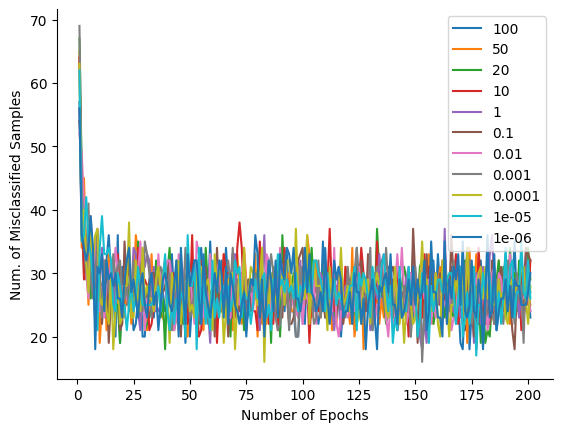

In [ ]:
for i in range(len(learning_rates)):
    # sns.lineplot(x=np.arange(1, len(misclassification_iter)+1), y=misclassification_iter)
    sns.lineplot(x=np.arange(1, len(misclassification_lr[i])+1), y=misclassification_lr[i], label=str(learning_rates[i]))
plt.xlabel("Number of Epochs")
plt.ylabel("Num. of Misclassified Samples")
sns.despine()
plt.show()

## Now visualize the decision boundary

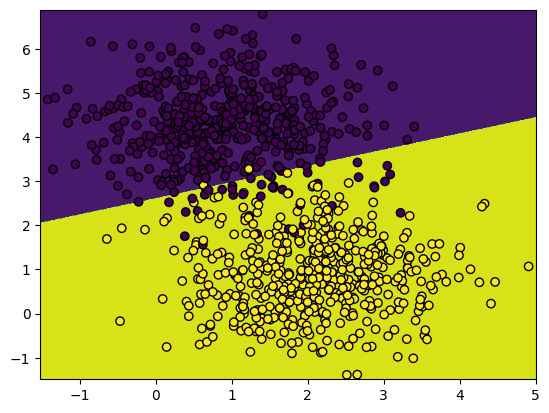

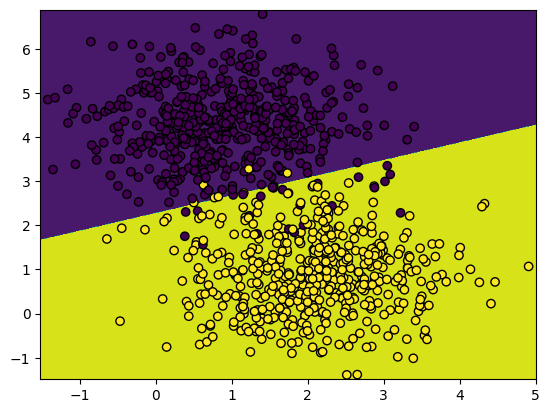

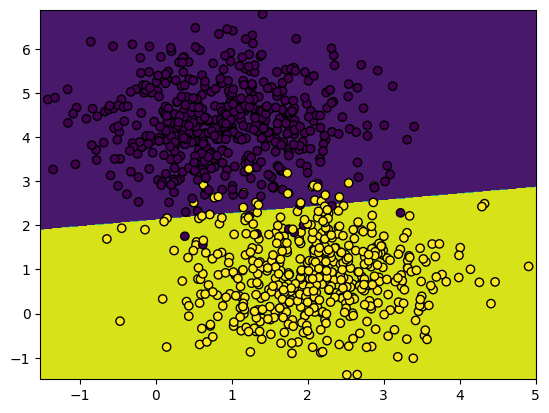

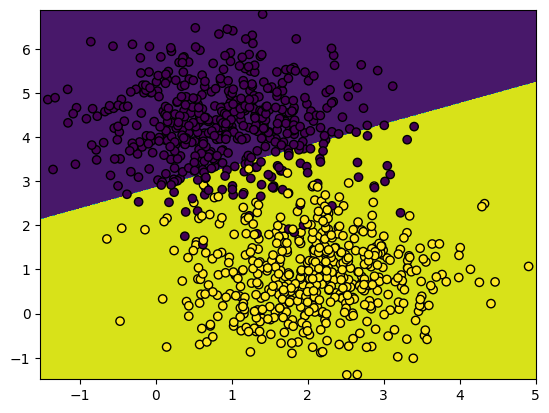

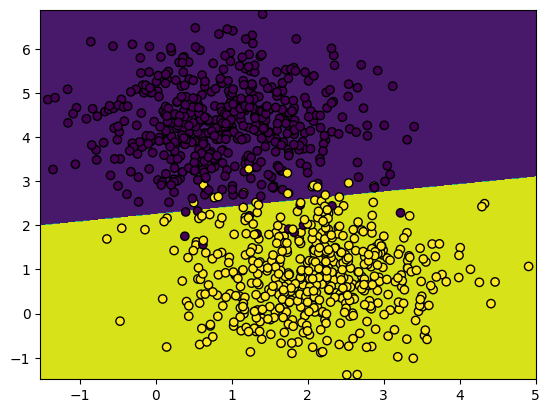

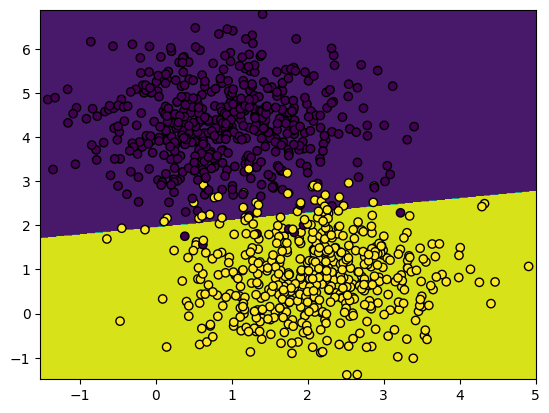

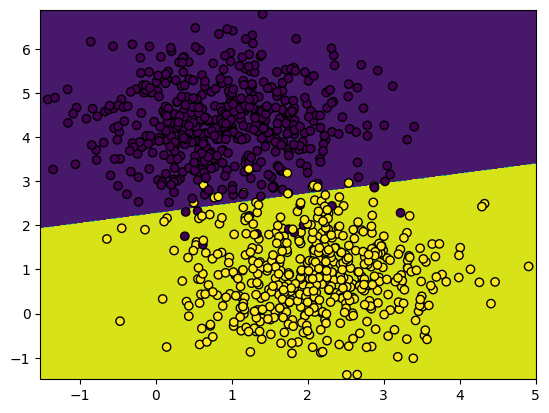

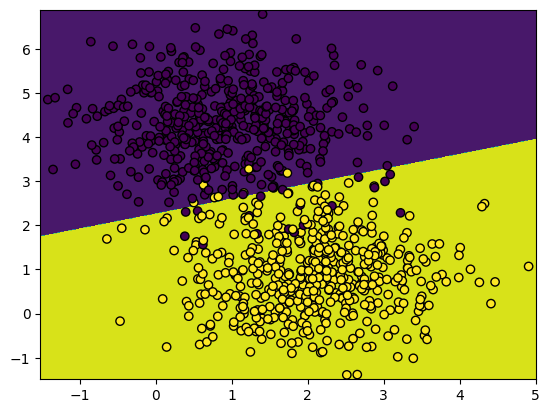

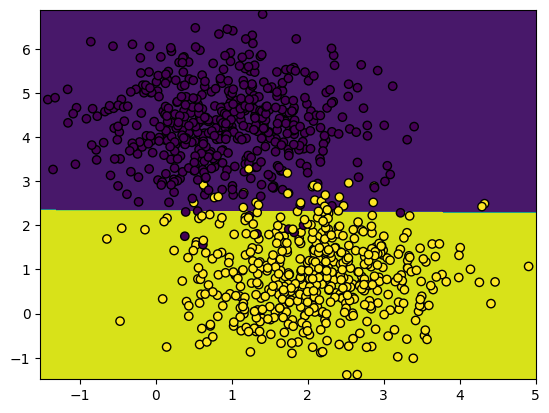

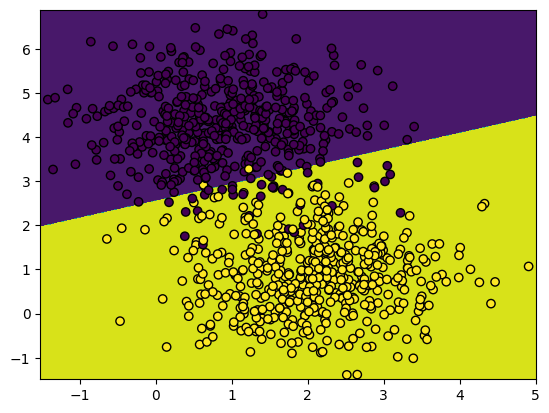

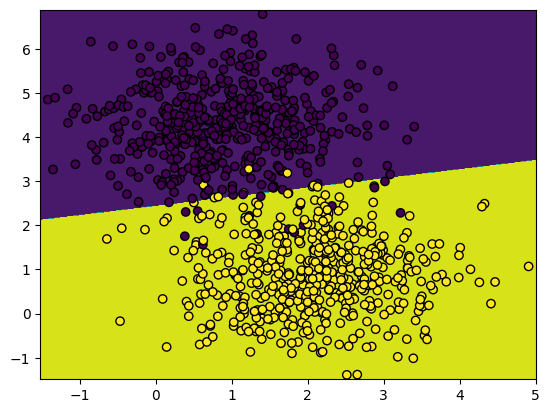

In [ ]:
for model in models:
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:,0].min()-0.1, X[:, 0].max()+0.1, 500),
        np.linspace(X[:, 1].min()-0.1, X[:, 1].max()+0.1, 500)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    preds = np.reshape([model.forward(grid[i]) for i in range(len(grid))], feature_1.shape)
    display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=preds)
    display.plot()
    display.ax_.scatter(X[:, 0], X[:, 1], c=Y, edgecolor="black")
    plt.show()
    plt.close()

## Check Accuracy on Test Set with our model

In [ ]:
scores = list()
for idx, model in enumerate(models):
    preds = [model.forward(X_test[i]) for i in range(len(X_test))]
    print("Accuracy on Test Set for learning rate, ", learning_rates[idx], ":", accuracy_score(Y_test, preds))
    scores.append(accuracy_score(Y_test, preds))

Accuracy on Test Set for learning rate,  100 : 0.935
Accuracy on Test Set for learning rate,  50 : 0.94
Accuracy on Test Set for learning rate,  20 : 0.955
Accuracy on Test Set for learning rate,  10 : 0.905
Accuracy on Test Set for learning rate,  1 : 0.96
Accuracy on Test Set for learning rate,  0.1 : 0.935
Accuracy on Test Set for learning rate,  0.01 : 0.955
Accuracy on Test Set for learning rate,  0.001 : 0.95
Accuracy on Test Set for learning rate,  0.0001 : 0.95
Accuracy on Test Set for learning rate,  1e-05 : 0.94
Accuracy on Test Set for learning rate,  1e-06 : 0.96


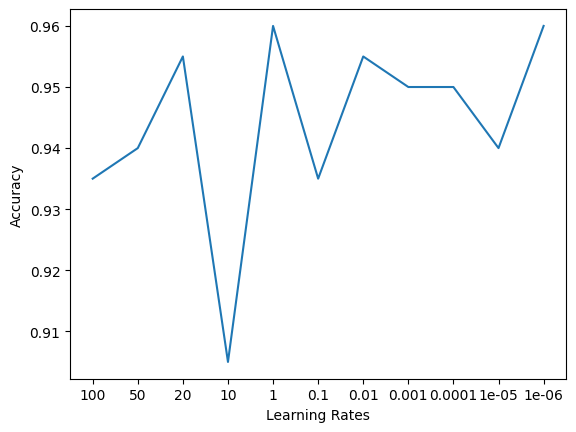

In [ ]:
sns.lineplot(x=np.arange(len(learning_rates)), y=scores)
plt.xticks(np.arange(len(learning_rates)), learning_rates)
plt.xlabel("Learning Rates")
plt.ylabel("Accuracy")
plt.show()

## Train the sklearn variant and check test set accuracy

In [ ]:
scores = list()
for idx, lr in enumerate(learning_rates):
    model = Perceptron(eta0=lr, shuffle=False)
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    print("Accuracy on Test Set for learning rate, ", learning_rates[idx], ":", accuracy_score(Y_test, preds))
    scores.append(accuracy_score(Y_test, preds))

Accuracy on Test Set for learning rate,  100 : 0.925
Accuracy on Test Set for learning rate,  50 : 0.925
Accuracy on Test Set for learning rate,  20 : 0.925
Accuracy on Test Set for learning rate,  10 : 0.925
Accuracy on Test Set for learning rate,  1 : 0.925
Accuracy on Test Set for learning rate,  0.1 : 0.925
Accuracy on Test Set for learning rate,  0.01 : 0.92
Accuracy on Test Set for learning rate,  0.001 : 0.92
Accuracy on Test Set for learning rate,  0.0001 : 0.92
Accuracy on Test Set for learning rate,  1e-05 : 0.92
Accuracy on Test Set for learning rate,  1e-06 : 0.92


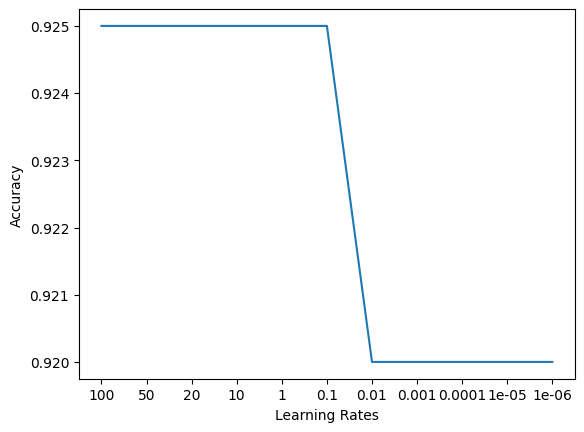

In [ ]:
sns.lineplot(x=np.arange(len(learning_rates)), y=scores)
plt.xticks(np.arange(len(learning_rates)), learning_rates)
plt.xlabel("Learning Rates")
plt.ylabel("Accuracy")
plt.show()